In [5]:
from pathlib import Path
from dv import AedatFile
import numpy as np
import h5py
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter


# ============================================================
# Project root = folder where THIS script/notebook is located
# ============================================================
PROJECT_DIR = Path.cwd()   # works for scripts and notebooks

# --- User input folder (user drops files here) ---
INPUT_DIR = PROJECT_DIR / "input"
INPUT_DIR.mkdir(exist_ok=True)

# --- Processing folders ---
EVENT_DIR   = PROJECT_DIR / "events"
RESULTS_DIR = PROJECT_DIR / "results"

EVENT_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

# ============================================================
# User file selection (place files inside ./input/)
# ============================================================
AEDAT_PATH = INPUT_DIR / "dvSave_test.aedat4"
MOTOR_CSV_RAW = INPUT_DIR / "serial_log_test.csv"

# --- File stems ---
aedat_name = AEDAT_PATH.stem
motor_name = MOTOR_CSV_RAW.stem

# ============================================================
# Event outputs
# ============================================================
H5_SPLIT    = EVENT_DIR / f"{aedat_name}_split.h5"
H5_SYNC     = EVENT_DIR / f"{aedat_name}_sync.h5"

# Final panorama in results/
H5_PANORAMA = RESULTS_DIR / f"{aedat_name}_results.h5"

# ============================================================
# Motor outputs (results folder)
# ============================================================
CSV_CLEAN = RESULTS_DIR / f"{motor_name}_clean.csv"

# Optional outputs
VIDEO_OUT = RESULTS_DIR / f"{motor_name}_preview.mp4"

# ============================================================
# Convert to strings (for existing code compatibility)
# ============================================================
AEDAT_PATH = str(AEDAT_PATH)
MOTOR_CSV_RAW = str(MOTOR_CSV_RAW)
H5_SPLIT = str(H5_SPLIT)
H5_SYNC = str(H5_SYNC)
H5_PANORAMA = str(H5_PANORAMA)
CSV_CLEAN = str(CSV_CLEAN)
VIDEO_OUT = str(VIDEO_OUT)

# ============================================================
# Info
# ============================================================
print("Project directory:", PROJECT_DIR)
print("Place your files here:", INPUT_DIR)
print()
print("Configured paths:")
print("AEDAT:", AEDAT_PATH)
print("Motor CSV:", MOTOR_CSV_RAW)
print("Split H5:", H5_SPLIT)
print("Sync H5:", H5_SYNC)
print("Results H5:", H5_PANORAMA)
print("Clean CSV:", CSV_CLEAN)
print("Video:", VIDEO_OUT)

Project directory: /home/maurice/Desktop/Master_Test
Place your files here: /home/maurice/Desktop/Master_Test/input

Configured paths:
AEDAT: /home/maurice/Desktop/Master_Test/input/dvSave_test.aedat4
Motor CSV: /home/maurice/Desktop/Master_Test/input/serial_log_test.csv
Split H5: /home/maurice/Desktop/Master_Test/events/dvSave_test_split.h5
Sync H5: /home/maurice/Desktop/Master_Test/events/dvSave_test_sync.h5
Results H5: /home/maurice/Desktop/Master_Test/results/dvSave_test_results.h5
Clean CSV: /home/maurice/Desktop/Master_Test/results/serial_log_test_clean.csv
Video: /home/maurice/Desktop/Master_Test/results/serial_log_test_preview.mp4


Step 1: Prepare the recorded aedat4.

- convert to h5 for numpy
- cut video to about the start of movement

In [3]:
INPUT = AEDAT_PATH
OUT = H5_SPLIT

CUT_SECONDS = 4.0
CUT_US = int(CUT_SECONDS * 1_000_000)  # timestamps in microseconds

CHUNK_EVENTS = 1_000_000
PRINT_EVERY_S = 1.0


def append_rows(dset, rows_np):
    """Append rows to a resizable HDF5 dataset."""
    if rows_np.size == 0:
        return
    n_old = dset.shape[0]
    n_new = n_old + rows_np.shape[0]
    dset.resize((n_new, 3))
    dset[n_old:n_new, :] = rows_np


with h5py.File(OUT, "w") as h5:
    dpos = h5.create_dataset(
        "pos", shape=(0, 3), maxshape=(None, 3),
        dtype=np.int64, chunks=(200_000, 3), compression="gzip"
    )
    dneg = h5.create_dataset(
        "neg", shape=(0, 3), maxshape=(None, 3),
        dtype=np.int64, chunks=(200_000, 3), compression="gzip"
    )

    buf_pos = []
    buf_neg = []

    with AedatFile(INPUT) as f:
        print(f.names)

        t0 = None
        last_print_t = None
        wall_start = time.time()

        kept_pos = 0
        kept_neg = 0

        for e in f["events"]:
            t = int(e.timestamp)

            if t0 is None:
                t0 = t
                last_print_t = t0

            # skip first CUT_SECONDS
            if t < t0 + CUT_US:
                continue

            if e.polarity:
                buf_pos.append((e.x, e.y, t))
                if len(buf_pos) >= CHUNK_EVENTS:
                    append_rows(dpos, np.asarray(buf_pos, dtype=np.int64))
                    kept_pos += len(buf_pos)
                    buf_pos.clear()
            else:
                buf_neg.append((e.x, e.y, t))
                if len(buf_neg) >= CHUNK_EVENTS:
                    append_rows(dneg, np.asarray(buf_neg, dtype=np.int64))
                    kept_neg += len(buf_neg)
                    buf_neg.clear()

            # progress print based on recording time
            if (t - last_print_t) >= int(PRINT_EVERY_S * 1_000_000):
                rec_s = (t - t0) / 1_000_000
                wall_s = time.time() - wall_start
                rate = (kept_pos + kept_neg) / wall_s if wall_s > 0 else 0.0
                print(f"processed {rec_s:7.2f} s | kept pos={kept_pos:,} neg={kept_neg:,} | {rate:,.0f} ev/s")
                last_print_t = t

        # flush remaining buffers
        if buf_pos:
            append_rows(dpos, np.asarray(buf_pos, dtype=np.int64))
            kept_pos += len(buf_pos)

        if buf_neg:
            append_rows(dneg, np.asarray(buf_neg, dtype=np.int64))
            kept_neg += len(buf_neg)

    h5.attrs["t0"] = t0
    h5.attrs["cut_us"] = CUT_US

print("saved:", OUT)

['events', 'imu', 'triggers']
processed    4.00 s | kept pos=0 neg=0 | 0 ev/s
processed    5.00 s | kept pos=0 neg=0 | 0 ev/s
processed    6.00 s | kept pos=2,000,000 neg=2,000,000 | 106,511 ev/s
processed    7.00 s | kept pos=4,000,000 neg=3,000,000 | 123,383 ev/s
processed    8.00 s | kept pos=4,000,000 neg=5,000,000 | 123,066 ev/s
processed    9.00 s | kept pos=5,000,000 neg=5,000,000 | 130,176 ev/s
processed   10.00 s | kept pos=7,000,000 neg=6,000,000 | 134,484 ev/s
processed   11.00 s | kept pos=8,000,000 neg=7,000,000 | 139,194 ev/s
processed   12.00 s | kept pos=9,000,000 neg=8,000,000 | 134,860 ev/s
processed   13.00 s | kept pos=9,000,000 neg=8,000,000 | 131,351 ev/s
processed   14.00 s | kept pos=11,000,000 neg=10,000,000 | 136,674 ev/s
processed   15.00 s | kept pos=11,000,000 neg=11,000,000 | 131,911 ev/s
processed   16.00 s | kept pos=12,000,000 neg=12,000,000 | 133,117 ev/s
processed   17.00 s | kept pos=12,000,000 neg=13,000,000 | 135,487 ev/s
processed   18.00 s | kept

Step 2: Match time by looking for spike increase

In [5]:
IN_H5 = H5_SPLIT   

BIN_US = 500          # 500 us bins (try 500 or 2000 too)
THRESH_Z = 4.0        # spike threshold in standard deviations
BASELINE_S = 1.0      # use first 1s to estimate baseline

with h5py.File(IN_H5, "r") as h5:
    dpos = h5["pos"]
    dneg = h5["neg"]

    tpos = dpos[:, 2] if dpos.shape[0] else np.array([], dtype=np.int64)
    tneg = dneg[:, 2] if dneg.shape[0] else np.array([], dtype=np.int64)

# merge timestamps only (cheap)
t_all = np.sort(np.concatenate([tpos, tneg]))
t0 = int(t_all[0])
t1 = int(t_all[-1])

# bin index for each event
bins = (t_all - t0) // BIN_US
nbins = int(bins[-1]) + 1

counts = np.bincount(bins.astype(np.int64), minlength=nbins)

# baseline from first BASELINE_S seconds
baseline_bins = int((BASELINE_S * 1_000_000) // BIN_US)
mu = counts[:baseline_bins].mean()
sigma = counts[:baseline_bins].std() + 1e-9

z = (counts - mu) / sigma
spike_bins = np.where(z > THRESH_Z)[0]

print(f"baseline mean={mu:.1f} ev/bin, std={sigma:.1f}, spikes found={len(spike_bins)}")

# print first few spike times
for b in spike_bins[:50]:
    t_spike = t0 + b * BIN_US
    print("spike at t =", t_spike, "count =", counts[b], "z =", z[b])

baseline mean=176.9 ev/bin, std=466.0, spikes found=9197
spike at t = 1759941381218139 count = 2400 z = 4.770284889594587
spike at t = 1759941381218639 count = 2042 z = 4.002106831657945
spike at t = 1759941381219139 count = 2674 z = 5.358220051255592
spike at t = 1759941381219639 count = 2470 z = 4.920487303157617
spike at t = 1759941381220139 count = 2928 z = 5.9032402376128745
spike at t = 1759941381220639 count = 2813 z = 5.656479129616468
spike at t = 1759941381221139 count = 3504 z = 7.139191526360099
spike at t = 1759941381221639 count = 3265 z = 6.626357571480608
spike at t = 1759941381222139 count = 4012 z = 8.229231899074664
spike at t = 1759941381222639 count = 3511 z = 7.154211767716402
spike at t = 1759941381223139 count = 4276 z = 8.795709573083808
spike at t = 1759941381223639 count = 3705 z = 7.570487028162516
spike at t = 1759941381224139 count = 4506 z = 9.289231789076624
spike at t = 1759941381224639 count = 3812 z = 7.800082146037433
spike at t = 1759941381225139 co

Step 3: Cut the h5 at the spike increase

In [6]:
IN_H5  = H5_SPLIT
OUT_H5 = H5_SYNC

# Still manual for calibration. Just copy and paste the first t that is being outpt by the cell above. Check in video output if that is the correct timeframe.
t_start_us = 1759941381218139

def cut_h5_at_timestamp(IN_H5, OUT_H5, t_start_us):

    with h5py.File(IN_H5, "r") as h5in, h5py.File(OUT_H5, "w") as h5out:

        for name in ["pos", "neg"]:
            if name not in h5in:
                continue

            d = h5in[name]
            print(f"Processing {name}, shape={d.shape}")

            if d.shape[0] == 0:
                h5out.create_dataset(name, data=d[:], dtype=d.dtype)
                continue

            # timestamps column
            t = d[:, 2]

            # find first index where t >= t_start_us
            i0 = int(np.searchsorted(t, t_start_us, side="left"))

            print(f"{name}: keeping {d.shape[0] - i0} events")

            if i0 >= d.shape[0]:
                # nothing left
                h5out.create_dataset(name, shape=(0, 3), dtype=np.int32)
                continue

            # slice remaining events
            ev = d[i0:, :].astype(np.int32)

            # shift timestamps so t_start_us -> 0
            ev[:, 2] -= int(t_start_us)

            h5out.create_dataset(name, data=ev, dtype=np.int32, chunks=True)

    print("Saved trimmed file:", OUT_H5)



cut_h5_at_timestamp(IN_H5, OUT_H5, t_start_us)

Processing pos, shape=(51107632, 3)
pos: keeping 50962084 events
Processing neg, shape=(50296397, 3)
neg: keeping 50172108 events
Saved trimmed file: /home/maurice/Desktop/Master_Test/events/dvSave_test_sync.h5


Step 4: Clean CSV to only get time and motor states

In [6]:
BASE_NAME = "serial_log_test"

CSV_IN  = INPUT_DIR / f"{BASE_NAME}.csv"
CSV_OUT = RESULTS_DIR / f"{BASE_NAME}_clean.csv"

# Convert to string for pandas
CSV_IN = str(CSV_IN)
CSV_OUT = str(CSV_OUT)
TZ_LOCAL = "Europe/Berlin"

df = pd.read_csv(CSV_IN)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["text"] = df["text"].astype(str)

# Extract every P line: "P 4 0 17"
p_re = r"^\s*P\s+([-+]?\d+)[,\s]+([-+]?\d+)[,\s]+([-+]?\d+)\s*$"
vals = df["text"].str.extract(p_re)
vals.columns = ["A", "B", "C"]

out = pd.concat([df["timestamp"], vals], axis=1)
out[["A","B","C"]] = out[["A","B","C"]].apply(pd.to_numeric, errors="coerce")
out = out.dropna(subset=["timestamp","A","B","C"]).reset_index(drop=True)

if out.empty:
    raise RuntimeError("No 'P a b c' lines found.")

# timestamp -> epoch us, then relative time
out["ts_us"] = (
    out["timestamp"].dt.tz_localize(TZ_LOCAL).dt.tz_convert("UTC").view("int64") // 1000
).astype(np.int64)

out = out.sort_values("ts_us").reset_index(drop=True)
t0 = int(out.loc[0, "ts_us"])
out["t_us"] = (out["ts_us"] - t0).astype(np.int64)

out_abs = out[["t_us", "A", "B", "C"]]
out_abs.to_csv(CSV_OUT, index=False)

print("Saved:", CSV_OUT)
print(out_abs.head(10))
print("Rows:", len(out_abs))

Saved: /home/maurice/Desktop/Master_Test/results/serial_log_test_clean.csv
   t_us    A    B    C
0     0  0.0  0.0  0.0
1     0  0.0  0.0  0.0
2  1000  0.0  0.0  0.0
3  1000  0.0  0.0  0.0
4  1000  0.0  0.0  0.0
5  1000  0.0  0.0  0.0
6  1000  0.0  0.0  0.0
7  1000  0.0  0.0  0.0
8  1000  0.0  0.0  0.0
9  1000  0.0  0.0  0.0
Rows: 29086


/tmp/ipykernel_46115/1588379934.py:29: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  out["timestamp"].dt.tz_localize(TZ_LOCAL).dt.tz_convert("UTC").view("int64") // 1000


Check for gaps

In [7]:
CSV_IN  = CSV_CLEAN
CSV_OUT = CSV_CLEAN

# Gap definition (seconds)
GAP_THRESHOLD = 0.5


def pick_time_column(cols):
    candidates = ["t_us", "ts_us", "time_us", "time", "t"]
    lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in lower:
            return lower[cand.lower()]
    raise RuntimeError(f"No time column found. Columns: {list(cols)}")


def main():
    print("Reading:", CSV_IN)
    df = pd.read_csv(CSV_IN)

    # --- detect time column ---
    t_col = pick_time_column(df.columns)
    print("Using time column:", t_col)

    t_us = df[t_col].to_numpy(np.int64)

    # --- compute time differences ---
    dt_s = np.diff(t_us) * 1e-6
    gap_idx = np.where(dt_s > GAP_THRESHOLD)[0]

    print(f"Found {len(gap_idx)} gap(s) > {GAP_THRESHOLD}s")

    if len(gap_idx) < 2:
        raise RuntimeError("Less than two gaps found — cannot cut at second gap.")

    # --- second gap ---
    second_gap = gap_idx[1]
    start_idx = second_gap + 1

    print("\nSecond gap info:")
    print(f"Index before gap: {second_gap}")
    print(f"Gap duration: {dt_s[second_gap]:.3f} s")
    print(f"Cutting CSV from index {start_idx}")

    # --- cut dataframe ---
    df_cut = df.iloc[start_idx:].reset_index(drop=True)

    # --- optional: re-zero time ---
    t0 = df_cut[t_col].iloc[0]
    df_cut[t_col] = df_cut[t_col] - t0

    # --- save ---
    df_cut.to_csv(CSV_OUT, index=False)

    print("Saved:", CSV_OUT)
    print(f"Rows before: {len(df)}")
    print(f"Rows after : {len(df_cut)}")


if __name__ == "__main__":
    main()

Reading: /home/maurice/Desktop/Master_Test/results/serial_log_test_clean.csv
Using time column: t_us
Found 2 gap(s) > 0.5s

Second gap info:
Index before gap: 23055
Gap duration: 855.174 s
Cutting CSV from index 23056
Saved: /home/maurice/Desktop/Master_Test/results/serial_log_test_clean.csv
Rows before: 29086
Rows after : 6030


Step 5: Do forward kinematics (should be fixed by how motor outputs motor states. --> It should return N_x,N_y)

In [8]:
CSV_IN  = CSV_CLEAN
CSV_OUT = CSV_CLEAN


# ----------------------------
# Mechanism geometry (same units everywhere)
# ----------------------------
d = 48.0
e = 80.0
f = 44.0
g = 83.5

# ----------------------------
# Starting pose anchor
# ----------------------------
HZ0 = 110.0   # fixed height anchor
NX0 = 0.0     # assume flat at start
NY0 = 0.0

# ----------------------------
# Motor conversion
# ----------------------------
STEPS_PER_REV = 3200.0
DEG_PER_STEP = 360.0 / STEPS_PER_REV

# ----------------------------
# FK solver settings
# ----------------------------
MAX_ITERS = 12
LAMBDA0 = 1e-2
EPS_HZ = 1e-4
EPS_N  = 1e-4

# ----------------------------
# Column names (auto-detect if missing)
# ----------------------------
COL_T_CAND = ["t_us", "ts_us", "time_us", "time", "t"]
COL_A_CAND = ["A_rel", "A", "a", "leg_a", "A_steps"]
COL_B_CAND = ["B_rel", "B", "b", "leg_b", "B_steps"]
COL_C_CAND = ["C_rel", "C", "c", "leg_c", "C_steps"]


def safe_acos(x: float) -> float:
    return np.arccos(np.clip(x, -1.0, 1.0))


def theta_deg(leg: str, hz: float, nx: float, ny: float) -> float:
    """Python port of your Machine::theta(leg, hz, nx, ny). Returns angle in degrees."""
    nmag = np.sqrt(nx * nx + ny * ny + 1.0)
    nxu = nx / nmag
    nyu = ny / nmag
    nzu = 1.0 / nmag

    if leg == "A":
        denom_inner = (nzu + 1.0 - nxu**2)
        if abs((nzu + 1.0) * denom_inner) < 1e-12:
            return np.nan

        frac = (nxu**4 - 3.0 * nxu**2 * nyu**2) / ((nzu + 1.0) * denom_inner)
        denom = (nzu + 1.0 - nxu**2 + frac)
        if abs(denom) < 1e-12:
            return np.nan

        y = d + (e / 2.0) * (1.0 - (nxu**2 + 3.0 * nzu**2 + 3.0 * nzu) / denom)
        z = hz + e * nyu
        mag = np.sqrt(y * y + z * z)
        if mag < 1e-12:
            return np.nan

        a1 = safe_acos(y / mag)
        a2 = safe_acos((mag * mag + f * f - g * g) / (2.0 * mag * f))
        return (a1 + a2) * (180.0 / np.pi)

    if leg == "B":
        x = (np.sqrt(3.0) / 2.0) * (e * (1.0 - (nxu**2 + np.sqrt(3.0) * nxu * nyu) / (nzu + 1.0)) - d)
        y = x / np.sqrt(3.0)
        z = hz - (e / 2.0) * (np.sqrt(3.0) * nxu + nyu)
        mag = np.sqrt(x * x + y * y + z * z)
        if mag < 1e-12:
            return np.nan

        a1 = safe_acos((np.sqrt(3.0) * x + y) / (-2.0 * mag))
        a2 = safe_acos((mag * mag + f * f - g * g) / (2.0 * mag * f))
        return (a1 + a2) * (180.0 / np.pi)

    if leg == "C":
        x = (np.sqrt(3.0) / 2.0) * (d - e * (1.0 - (nxu**2 - np.sqrt(3.0) * nxu * nyu) / (nzu + 1.0)))
        y = -x / np.sqrt(3.0)
        z = hz + (e / 2.0) * (np.sqrt(3.0) * nxu - nyu)
        mag = np.sqrt(x * x + y * y + z * z)
        if mag < 1e-12:
            return np.nan

        a1 = safe_acos((np.sqrt(3.0) * x - y) / (2.0 * mag))
        a2 = safe_acos((mag * mag + f * f - g * g) / (2.0 * mag * f))
        return (a1 + a2) * (180.0 / np.pi)

    raise ValueError("leg must be 'A', 'B', or 'C'")


def residuals(u: np.ndarray, thA: float, thB: float, thC: float) -> np.ndarray:
    hz, nx, ny = u
    return np.array(
        [
            theta_deg("A", hz, nx, ny) - thA,
            theta_deg("B", hz, nx, ny) - thB,
            theta_deg("C", hz, nx, ny) - thC,
        ],
        dtype=float,
    )


def jacobian_fd(u: np.ndarray, thA: float, thB: float, thC: float) -> np.ndarray:
    J = np.zeros((3, 3), dtype=float)
    steps = np.array([EPS_HZ, EPS_N, EPS_N], dtype=float)

    for k in range(3):
        du = np.zeros(3, dtype=float)
        du[k] = steps[k]
        fp = residuals(u + du, thA, thB, thC)
        fm = residuals(u - du, thA, thB, thC)
        J[:, k] = (fp - fm) / (2.0 * steps[k])

    return J


def solve_fk(thA: float, thB: float, thC: float, u0: np.ndarray) -> np.ndarray:
    """Damped Gauss-Newton (LM) solve for u=[hz,nx,ny]."""
    u = u0.astype(float).copy()
    lam = LAMBDA0

    for _ in range(MAX_ITERS):
        F = residuals(u, thA, thB, thC)
        if not np.all(np.isfinite(F)):
            u += np.array([0.0, 1e-3, -1e-3])
            continue

        if np.linalg.norm(F) < 1e-3:
            break

        J = jacobian_fd(u, thA, thB, thC)
        A = (J.T @ J) + lam * np.eye(3)
        b = -(J.T @ F)

        try:
            du = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            lam *= 10.0
            continue

        u_new = u + du
        F_new = residuals(u_new, thA, thB, thC)

        if np.all(np.isfinite(F_new)) and np.linalg.norm(F_new) < np.linalg.norm(F):
            u = u_new
            lam = max(lam / 2.0, 1e-6)
        else:
            lam = min(lam * 5.0, 1e6)

    return u


def normal_from_nxny(nx: float, ny: float) -> np.ndarray:
    v = np.array([nx, ny, 1.0], dtype=float)
    return v / np.linalg.norm(v)


def roll_pitch_from_normal(n: np.ndarray) -> tuple[float, float]:
    nx, ny, nz = n
    pitch = np.degrees(np.arctan2(nx, nz))
    roll = -np.degrees(np.arctan2(ny, nz))
    return roll, pitch


def pick_first_existing(cols, candidates):
    lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in lower:
            return lower[cand.lower()]
    return None


def main():
    mot = pd.read_csv(CSV_IN)

    t_col = pick_first_existing(mot.columns, COL_T_CAND)
    a_col = pick_first_existing(mot.columns, COL_A_CAND)
    b_col = pick_first_existing(mot.columns, COL_B_CAND)
    c_col = pick_first_existing(mot.columns, COL_C_CAND)

    if a_col is None or b_col is None or c_col is None:
        raise RuntimeError(f"Could not detect A/B/C columns. Found: {list(mot.columns)}")

    t_us = mot[t_col].to_numpy(np.int64) if t_col is not None else np.arange(len(mot), dtype=np.int64)

    A_steps = mot[a_col].to_numpy(float)
    B_steps = mot[b_col].to_numpy(float)
    C_steps = mot[c_col].to_numpy(float)

    print("Using columns:", {"t": t_col, "A": a_col, "B": b_col, "C": c_col})
    print("Step ranges:", (A_steps.min(), A_steps.max()), (B_steps.min(), B_steps.max()), (C_steps.min(), C_steps.max()))

    # Convert steps -> degrees (treat columns as RELATIVE steps), anchored by (HZ0, flat)
    thA_base = theta_deg("A", HZ0, NX0, NY0)
    thB_base = theta_deg("B", HZ0, NX0, NY0)
    thC_base = theta_deg("C", HZ0, NX0, NY0)

    if not np.isfinite(thA_base) or not np.isfinite(thB_base) or not np.isfinite(thC_base):
        raise RuntimeError("Baseline IK returned NaN. Check geometry and HZ0.")

    print(f"Baseline from hz={HZ0} flat: thA0={thA_base:.3f} thB0={thB_base:.3f} thC0={thC_base:.3f}")

    thA = thA_base + A_steps * DEG_PER_STEP
    thB = thB_base + B_steps * DEG_PER_STEP
    thC = thC_base + C_steps * DEG_PER_STEP

    print("Angle ranges (deg):", (thA.min(), thA.max()), (thB.min(), thB.max()), (thC.min(), thC.max()))

    # Solve FK per sample (warm-start)
    u = np.array([HZ0, 0.0, 0.0], dtype=float)
    normals = np.zeros((len(thA), 3), dtype=float)

    for i in range(len(thA)):
        u = solve_fk(thA[i], thB[i], thC[i], u)
        hz, nx, ny = u
        normals[i] = normal_from_nxny(nx, ny)

        if i in (0, 1, 2, 3, 4) or (i % 50000 == 0 and i > 0):
            F = residuals(u, thA[i], thB[i], thC[i])
            print(f"i={i}  |res|={np.linalg.norm(F):.4f} deg  u=[hz={hz:.3f}, nx={nx:.6f}, ny={ny:.6f}]")

    print("First 10 normals and roll/pitch:")
    for i in range(min(10, len(normals))):
        n = normals[i]
        roll, pitch = roll_pitch_from_normal(n)
        print(f"{i:3d}: n=({n[0]: .6f}, {n[1]: .6f}, {n[2]: .6f})  roll={roll: .3f}°  pitch={pitch: .3f}°")

    out = pd.DataFrame({"t_us": t_us, "nx": normals[:, 0], "ny": normals[:, 1], "nz": normals[:, 2]})
    out.to_csv(CSV_OUT, index=False)
    print("Saved:", CSV_OUT)


if __name__ == "__main__":
    main()

Using columns: {'t': 't_us', 'A': 'A', 'B': 'B', 'C': 'C'}
Step ranges: (0.0, 416.0) (0.0, 416.0) (0.0, 416.0)
Baseline from hz=110.0 flat: thA0=142.874 thB0=142.874 thC0=142.874
Angle ranges (deg): (142.87430007400621, 189.67430007400623) (142.87430007400621, 189.67430007400623) (142.87430007400621, 189.67430007400623)
i=0  |res|=0.0000 deg  u=[hz=110.000, nx=0.000000, ny=0.000000]
i=1  |res|=0.0000 deg  u=[hz=110.000, nx=0.000000, ny=0.000000]
i=2  |res|=0.0000 deg  u=[hz=110.000, nx=0.000000, ny=0.000000]
i=3  |res|=0.0000 deg  u=[hz=110.000, nx=0.000000, ny=0.000000]
i=4  |res|=0.0000 deg  u=[hz=110.000, nx=0.000000, ny=0.000000]
First 10 normals and roll/pitch:
  0: n=( 0.000000,  0.000000,  1.000000)  roll=-0.000°  pitch= 0.000°
  1: n=( 0.000000,  0.000000,  1.000000)  roll=-0.000°  pitch= 0.000°
  2: n=( 0.000000,  0.000000,  1.000000)  roll=-0.000°  pitch= 0.000°
  3: n=( 0.000000,  0.000000,  1.000000)  roll=-0.000°  pitch= 0.000°
  4: n=( 0.000000,  0.000000,  1.000000)  rol

Sanity Check: flip sign function at the end if directions mismatch

Saved: /home/maurice/Desktop/Master_Test/results/serial_log_test_preview.mp4


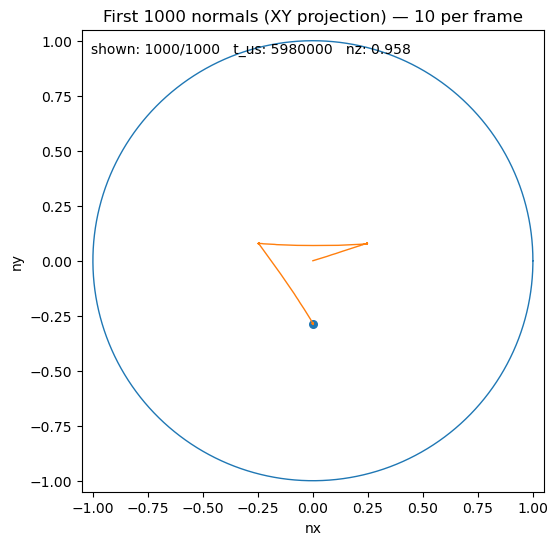

In [11]:
# ---------- CONFIG ----------
CSV_PATH = CSV_CLEAN     # from the configuration cell
OUT_MP4  = VIDEO_OUT      # from the configuration cell

N = 1000                 # first N vectors
CHUNK = 10                # vectors added per frame
FPS = 15
DPI = 110
# ---------------------------

# Load first N rows
df = pd.read_csv(CSV_PATH).head(N)

# Expecting columns: t_us, nx, ny, nz
t  = df["t_us"].to_numpy()
nx = df["nx"].to_numpy()
ny = df["ny"].to_numpy()
nz = df["nz"].to_numpy()

# Number of animation frames
n_frames = int(np.ceil(len(df) / CHUNK))

# Plot setup (XY projection of normals)
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("First 1000 normals (XY projection) — 10 per frame")
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("nx")
ax.set_ylabel("ny")

# Unit circle guide
theta = np.linspace(0, 2*np.pi, 400)
ax.plot(np.cos(theta), np.sin(theta), linewidth=1)

# Artists
trail, = ax.plot([], [], linewidth=1)     # path of points
pt = ax.scatter([], [], s=30)             # current point
txt = ax.text(0.02, 0.95, "", transform=ax.transAxes)

def init():
    trail.set_data([], [])
    pt.set_offsets(np.empty((0, 2)))
    txt.set_text("")
    return trail, pt, txt

def update(frame):
    end = min((frame + 1) * CHUNK, len(df))

    # Show all points up to 'end'
    trail.set_data(nx[:end], ny[:end])

    # Current point = last shown
    pt.set_offsets(np.array([[nx[end-1], ny[end-1]]]))

    # Overlay text
    txt.set_text(f"shown: {end}/{len(df)}   t_us: {t[end-1]}   nz: {nz[end-1]:.3f}")
    return trail, pt, txt

anim = FuncAnimation(
    fig,
    update,
    frames=n_frames,
    init_func=init,
    interval=1000 / FPS,
    blit=True
)

# Save MP4 (requires ffmpeg installed)
writer = FFMpegWriter(fps=FPS, metadata={"title": "Normals XY (chunked)"}, bitrate=1800)
anim.save(OUT_MP4, writer=writer, dpi=DPI)

print(f"Saved: {OUT_MP4}")

In [14]:
def flip_xy_signs(
    input_csv,
    output_csv=None,
    flip_x=True,
    flip_y=False,
    x_col="nx",
    y_col="ny"
):
    """
    Flip signs of X and/or Y columns in a CSV.
    """

    df = pd.read_csv(input_csv)

    # Flip signs
    if flip_x:
        if x_col not in df.columns:
            raise ValueError(f"Column '{x_col}' not found")
        df[x_col] = -df[x_col]

    if flip_y:
        if y_col not in df.columns:
            raise ValueError(f"Column '{y_col}' not found")
        df[y_col] = -df[y_col]

    # Output path
    if output_csv is None:
        input_path = Path(input_csv)
        output_csv = str(input_path.with_name(input_path.stem + "_flipped.csv"))

    df.to_csv(output_csv, index=False)
    print(f"Saved: {output_csv}")
    return output_csv


flip_xy_signs(CSV_CLEAN, CSV_CLEAN, flip_x=True, flip_y=False)

Saved: /home/maurice/Desktop/Master_Test/results/serial_log_test_clean.csv


'/home/maurice/Desktop/Master_Test/results/serial_log_test_clean.csv'

Step 4: Interpolate vectors for smooth correction, apply rotation caused by yaw in mirror, apply homography

In [15]:
IN_H5       = H5_SYNC
NORMAL_CSV  = CSV_CLEAN
OUT_H5      = H5_PANORAMA

H, W        = 480, 640
PAN_H, PAN_W = 1440, 1920          # panorama canvas size 
WINDOW_US   = 5000                 # update frequency between vector and sliding window


#  intrinsics for calibration
FX_PX       = 1900.0
FY_PX       = 2800.0

DROP_OOB    = True                 # drop events outside panorama

# Optional: force a desired starting orientation (reference normal) relative to camera
# Enter initial orientation of mirror infront of the camera (~ 45-60 Degrees )
USE_DESIRED_START = True
START_YAW_DEG     = 60.0
START_PITCH_DEG   = 0.0
# ============================


def load_normals_csv(path):
    # expects header: t_us,nx,ny,nz
    arr = np.loadtxt(path, delimiter=",", skiprows=1)
    tN = arr[:, 0].astype(np.int64)
    n = arr[:, 1:4].astype(np.float64)
    idx = np.argsort(tN)
    tN = tN[idx]
    n = n[idx]
    n /= (np.linalg.norm(n, axis=1, keepdims=True) + 1e-12)
    return tN, n

def interp_normals(tN, nN, t_query_us):
    tq = t_query_us.astype(float)
    t = tN.astype(float)
    nx = np.interp(tq, t, nN[:, 0])
    ny = np.interp(tq, t, nN[:, 1])
    nz = np.interp(tq, t, nN[:, 2])
    n = np.column_stack([nx, ny, nz])
    n /= (np.linalg.norm(n, axis=1, keepdims=True) + 1e-12)
    return n

# ----------------------------
# Rotation utilities
# ----------------------------
def _skew(v):
    vx, vy, vz = v
    return np.array([[0.0, -vz,  vy],
                     [vz,  0.0, -vx],
                     [-vy, vx,  0.0]], dtype=np.float64)

def rot_from_a_to_b(a, b, eps=1e-12):
    """
    Return 3x3 rotation R such that R @ a ≈ b.
    a,b are 3-vectors (will be normalized). Handles parallel/opposite.
    """
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    a = a / (np.linalg.norm(a) + eps)
    b = b / (np.linalg.norm(b) + eps)

    v = np.cross(a, b)
    c = float(np.dot(a, b))
    s = float(np.linalg.norm(v))

    if s < 1e-9:
        if c > 0.0:
            return np.eye(3, dtype=np.float64)
        tmp = np.array([1.0, 0.0, 0.0]) if abs(a[0]) < 0.9 else np.array([0.0, 1.0, 0.0])
        axis = np.cross(a, tmp)
        axis = axis / (np.linalg.norm(axis) + eps)
        K = _skew(axis)
        return np.eye(3) + 2.0 * (K @ K)

    K = _skew(v / s)
    R = np.eye(3) + K * s + (K @ K) * (1.0 - c)
    return R

def desired_normal_from_yaw_pitch(yaw_deg, pitch_deg):
    yaw = np.deg2rad(yaw_deg)
    pitch = np.deg2rad(pitch_deg)

    cy, sy = np.cos(yaw), np.sin(yaw)
    cx, sx = np.cos(pitch), np.sin(pitch)

    v = np.array([sy, 0.0, cy], dtype=np.float64)
    v = np.array([v[0],
                  cx * v[1] - sx * v[2],
                  sx * v[1] + cx * v[2]], dtype=np.float64)
    v /= (np.linalg.norm(v) + 1e-12)
    return v

# ----------------------------
# Homography utilities
# ----------------------------
def build_K(fx_px, fy_px, cx, cy):
    K = np.array([[fx_px, 0.0,  cx],
                  [0.0,  fy_px, cy],
                  [0.0,  0.0,   1.0]], dtype=np.float64)
    return K

def apply_homography_xy(xy, H):
    if xy.shape[0] == 0:
        return xy
    P = np.column_stack([xy, np.ones((xy.shape[0],), dtype=np.float64)])
    Q = (H @ P.T).T
    w = Q[:, 2:3]
    w = np.where(np.abs(w) < 1e-12, 1e-12, w)
    return Q[:, :2] / w


# panorama base offset puts the *reference sensor window* at the center
BASE_X = (PAN_W - W) * 0.5
BASE_Y = (PAN_H - H) * 0.5

# principal point (use true cx/cy if you have it)
CX = (W - 1) * 0.5
CY = (H - 1) * 0.5

K = build_K(FX_PX, FY_PX, CX, CY)
Kinv = np.linalg.inv(K)

# ---- load normals
tN, nN = load_normals_csv(NORMAL_CSV)
n_ref_meas = nN[0]

if USE_DESIRED_START:
    n_ref = desired_normal_from_yaw_pitch(START_YAW_DEG, START_PITCH_DEG)
    R_cal = rot_from_a_to_b(n_ref_meas, n_ref)
else:
    n_ref = n_ref_meas
    R_cal = np.eye(3, dtype=np.float64)

with h5py.File(IN_H5, "r") as h5in, h5py.File(OUT_H5, "w") as h5out:
    dpos = h5in["pos"]
    dneg = h5in["neg"]

    tpos = dpos[:, 2].astype(np.int64) if dpos.shape[0] else np.array([], np.int64)
    tneg = dneg[:, 2].astype(np.int64) if dneg.shape[0] else np.array([], np.int64)

    t_min = min(tpos[0] if len(tpos) else 10**30, tneg[0] if len(tneg) else 10**30)
    t_max = max(tpos[-1] if len(tpos) else 0,      tneg[-1] if len(tneg) else 0)

    times = np.arange(int(t_min), int(t_max), int(WINDOW_US), dtype=np.int64)
    print("windows:", len(times), "WINDOW_US:", WINDOW_US)

    pos_out = h5out.create_dataset("pos", shape=(0, 3), maxshape=(None, 3),
                                   dtype=np.int32, chunks=True)
    neg_out = h5out.create_dataset("neg", shape=(0, 3), maxshape=(None, 3),
                                   dtype=np.int32, chunks=True)

    def append_rows(ds, rows):
        n0 = ds.shape[0]
        ds.resize((n0 + rows.shape[0], 3))
        ds[n0:n0 + rows.shape[0], :] = rows

    pos_i0 = np.searchsorted(tpos, times, side="left") if len(tpos) else np.zeros(len(times), dtype=int)
    pos_i1 = np.searchsorted(tpos, times + WINDOW_US, side="left") if len(tpos) else np.zeros(len(times), dtype=int)
    neg_j0 = np.searchsorted(tneg, times, side="left") if len(tneg) else np.zeros(len(times), dtype=int)
    neg_j1 = np.searchsorted(tneg, times + WINDOW_US, side="left") if len(tneg) else np.zeros(len(times), dtype=int)

    t_mid = times + (WINDOW_US // 2)
    n_mid = interp_normals(tN, nN, t_mid)

    n_mid_cal = (R_cal @ n_mid.T).T
    n_mid_cal /= (np.linalg.norm(n_mid_cal, axis=1, keepdims=True) + 1e-12)

    for k in range(len(times)):
        i0, i1 = int(pos_i0[k]), int(pos_i1[k])
        j0, j1 = int(neg_j0[k]), int(neg_j1[k])

        pos = np.asarray(dpos[i0:i1, :]) if i1 > i0 else np.zeros((0, 3), dtype=np.int64)
        neg = np.asarray(dneg[j0:j1, :]) if j1 > j0 else np.zeros((0, 3), dtype=np.int64)

        if pos.shape[0] == 0 and neg.shape[0] == 0:
            continue

        n_cur = n_mid_cal[k]

        R_ref_to_cur = rot_from_a_to_b(n_ref, n_cur)
        R_cur_to_ref = R_ref_to_cur.T

        H_cur_to_ref = K @ R_cur_to_ref @ Kinv

        def place_events(ev):
            if ev.shape[0] == 0:
                return ev.astype(np.int32)

            xy = ev[:, :2].astype(np.float64)
            xy_w = apply_homography_xy(xy, H_cur_to_ref)

            x = xy_w[:, 0] + BASE_X
            y = xy_w[:, 1] + BASE_Y
            t = ev[:, 2].astype(np.int32)

            if DROP_OOB:
                valid = (x >= 0) & (x < PAN_W) & (y >= 0) & (y < PAN_H)
                x = x[valid]; y = y[valid]; t = t[valid]

            return np.column_stack([np.round(x).astype(np.int32),
                                    np.round(y).astype(np.int32),
                                    t])

        pos_w = place_events(pos)
        neg_w = place_events(neg)

        if pos_w.shape[0]:
            append_rows(pos_out, pos_w)
        if neg_w.shape[0]:
            append_rows(neg_out, neg_w)

        if k % 200 == 0:
            ang = np.rad2deg(np.arccos(np.clip(np.dot(n_ref, n_cur), -1.0, 1.0)))
            print(f"k={k}/{len(times)} ang(ref->cur)={ang:.2f}deg "
                  f"out pos={pos_out.shape[0]} neg={neg_out.shape[0]}")

print("Saved panorama events:", OUT_H5)

windows: 8771 WINDOW_US: 5000
k=0/8771 ang(ref->cur)=0.00deg out pos=13257 neg=16362
k=200/8771 ang(ref->cur)=14.89deg out pos=2629126 neg=2230804
k=400/8771 ang(ref->cur)=14.87deg out pos=3982805 neg=3537521
k=600/8771 ang(ref->cur)=15.04deg out pos=4808799 neg=5266512
k=800/8771 ang(ref->cur)=14.88deg out pos=5062726 neg=5504030
k=1000/8771 ang(ref->cur)=16.70deg out pos=7025914 neg=6118345
k=1200/8771 ang(ref->cur)=16.72deg out pos=7659382 neg=6711191
k=1400/8771 ang(ref->cur)=15.96deg out pos=8726343 neg=8341149
k=1600/8771 ang(ref->cur)=16.02deg out pos=8996623 neg=8586714
k=1800/8771 ang(ref->cur)=0.09deg out pos=10567620 neg=10439757
k=2000/8771 ang(ref->cur)=0.09deg out pos=11565294 neg=11405792
k=2200/8771 ang(ref->cur)=15.03deg out pos=12209594 neg=12546466
k=2400/8771 ang(ref->cur)=14.95deg out pos=12477047 neg=12796450
k=2600/8771 ang(ref->cur)=14.91deg out pos=15432488 neg=14878129
k=2800/8771 ang(ref->cur)=15.06deg out pos=16799055 neg=16198966
k=3000/8771 ang(ref->cur)=0